# Background Knowledge

## Self- Attention

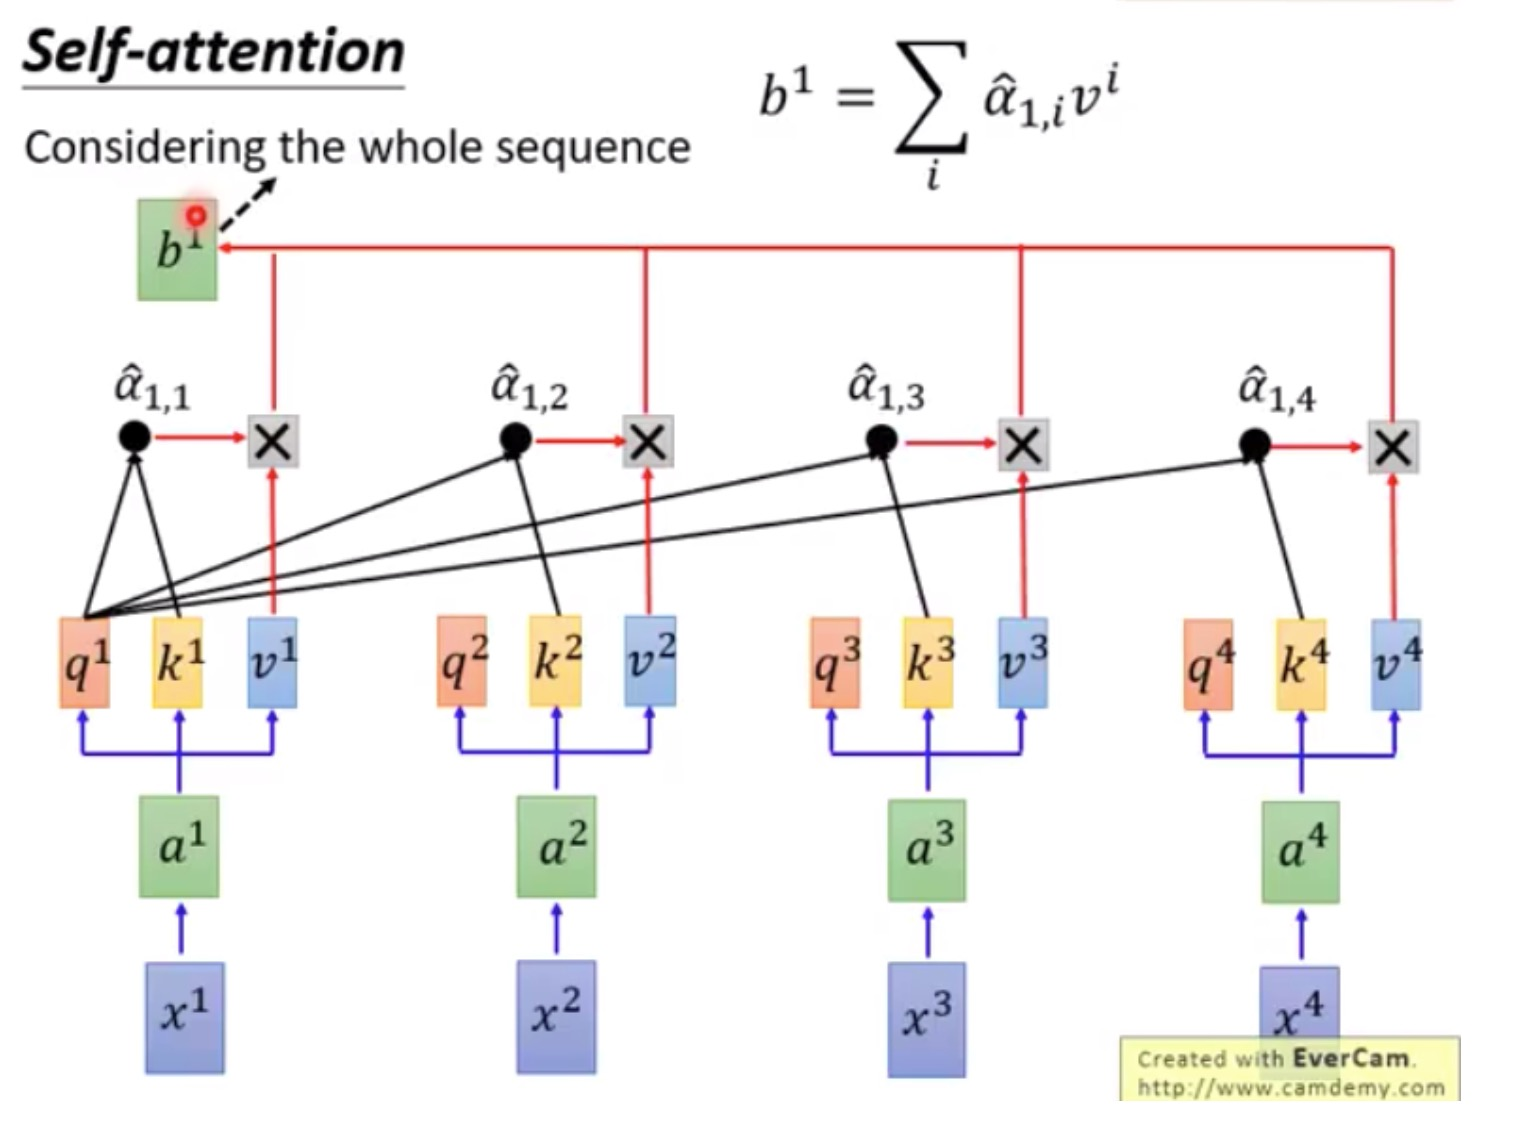

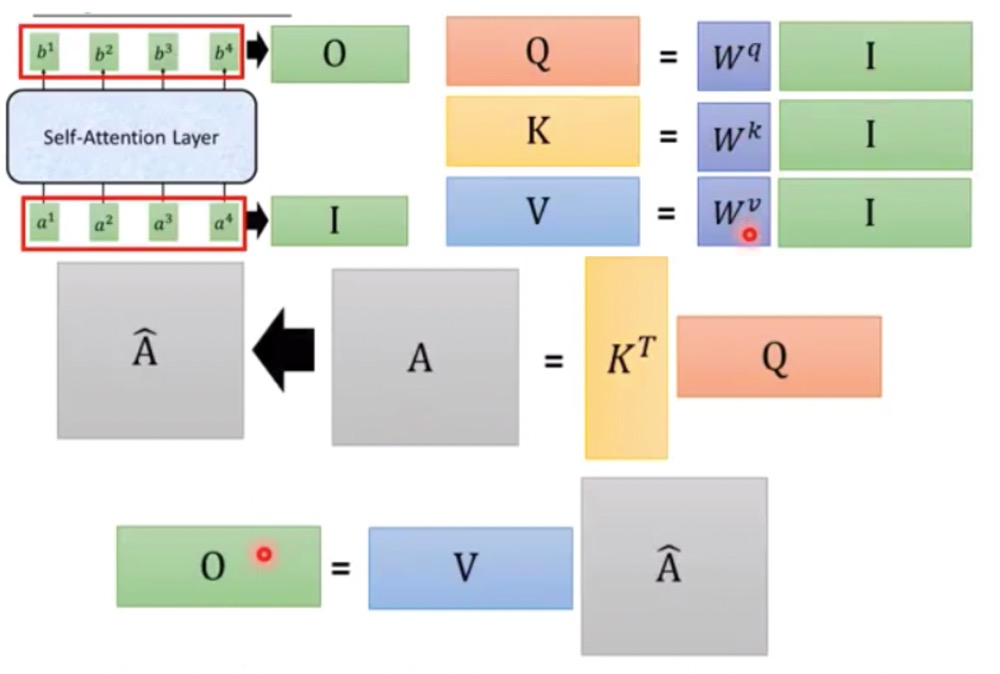

# Transformer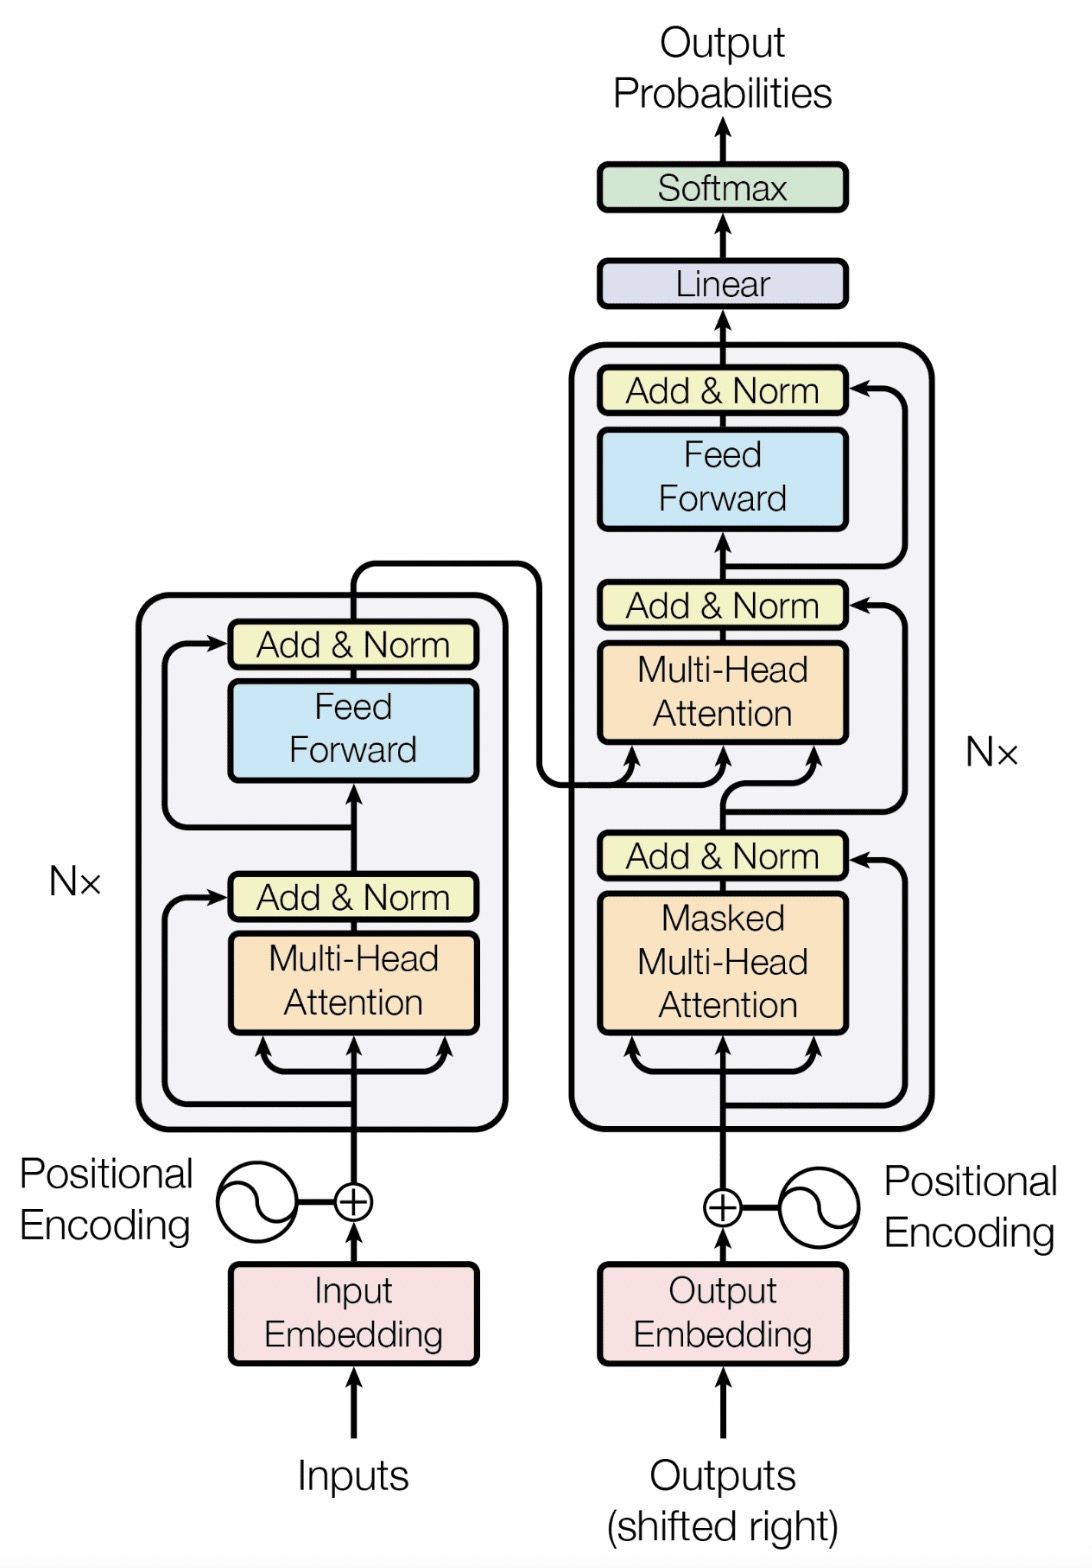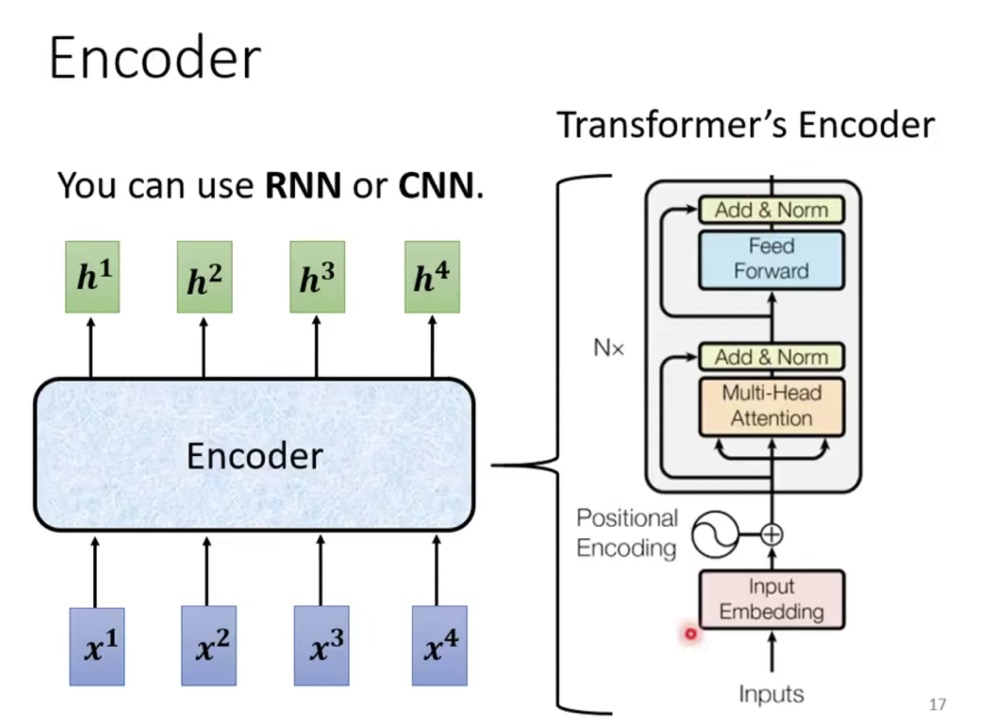

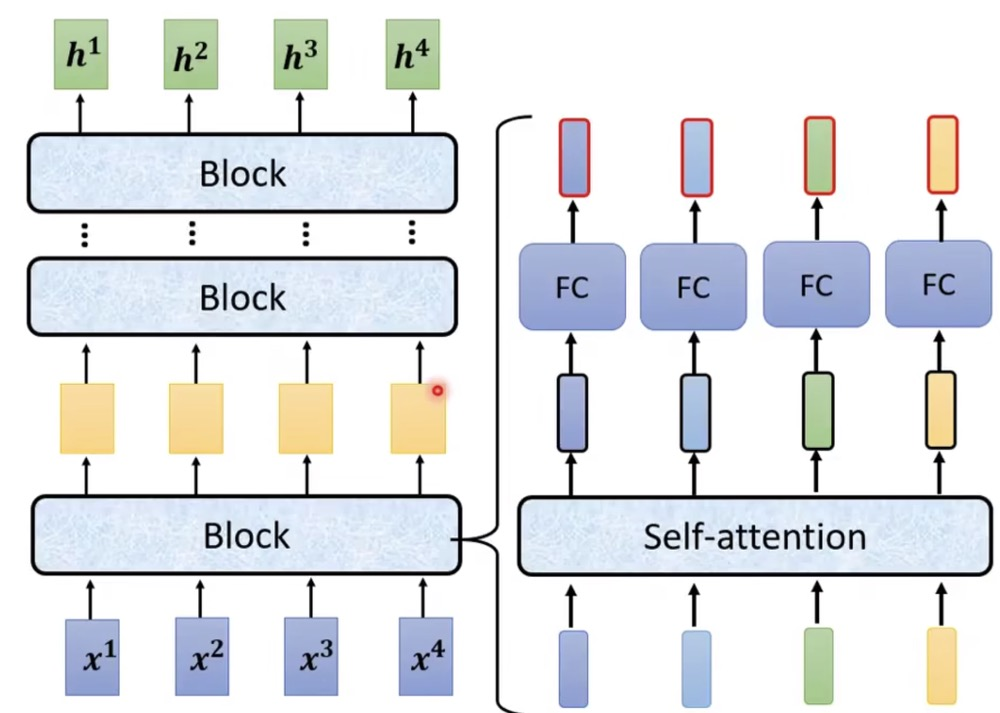

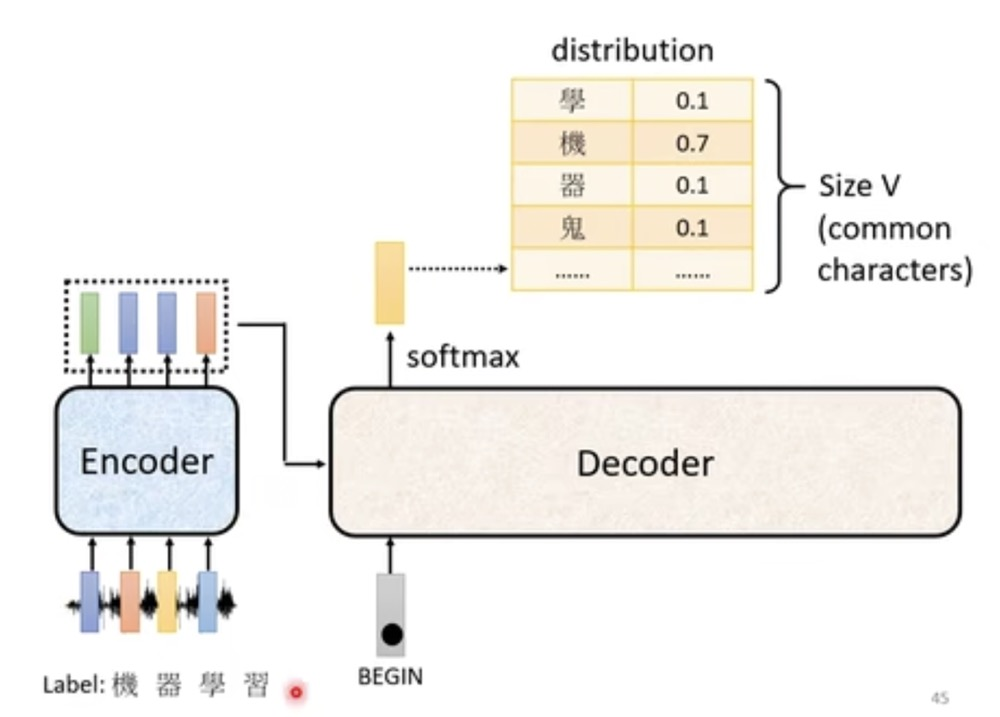

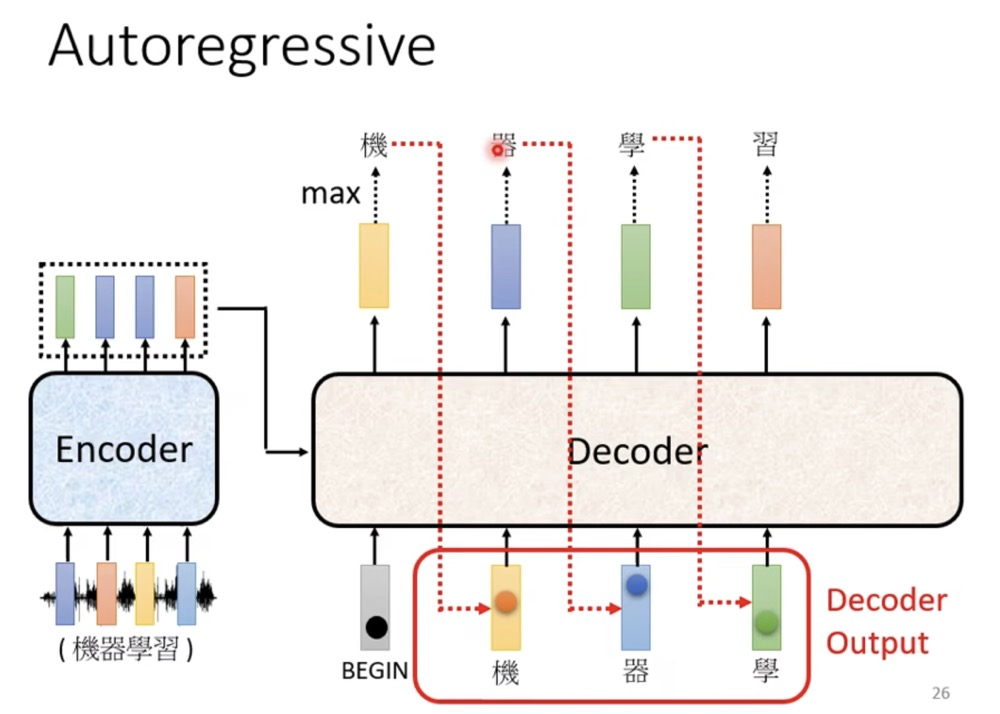

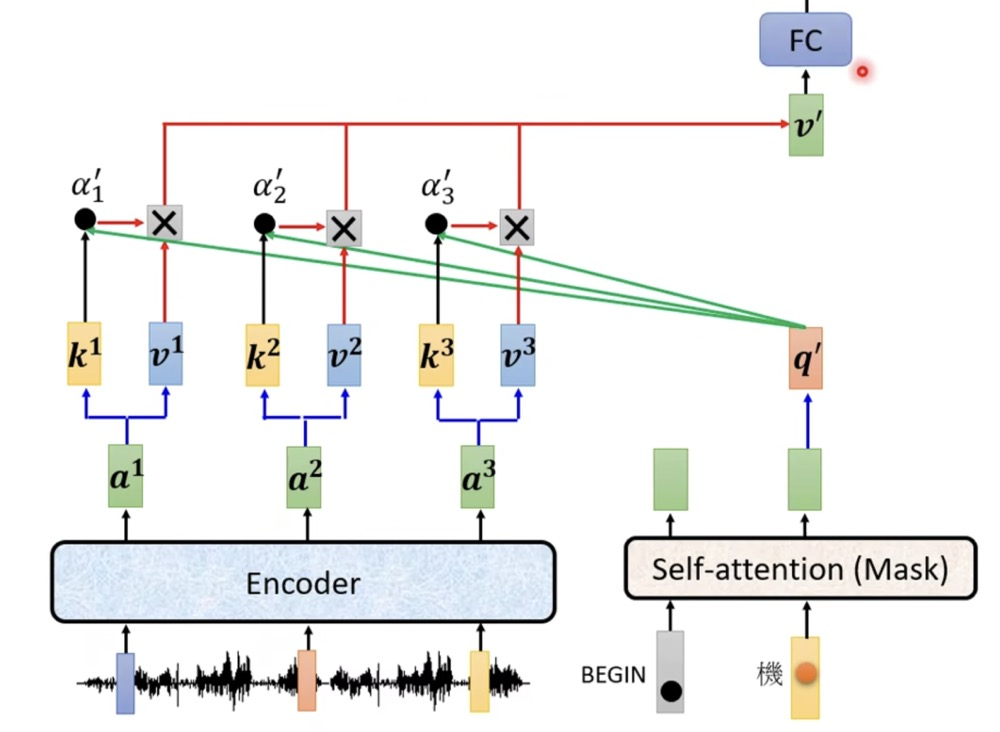

## BERT

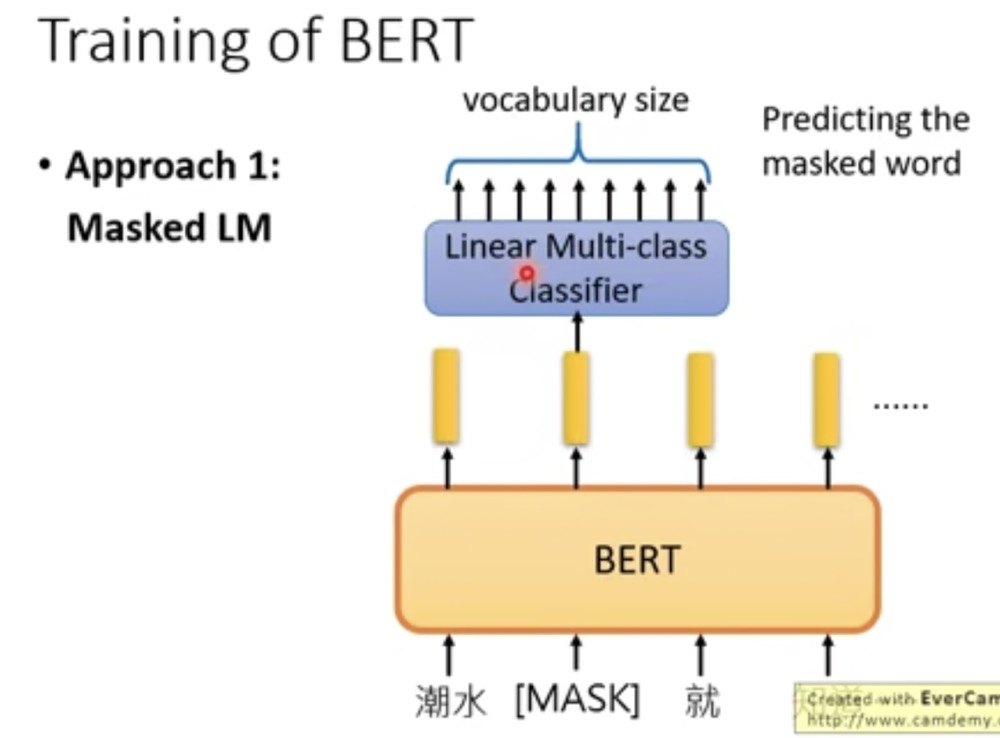

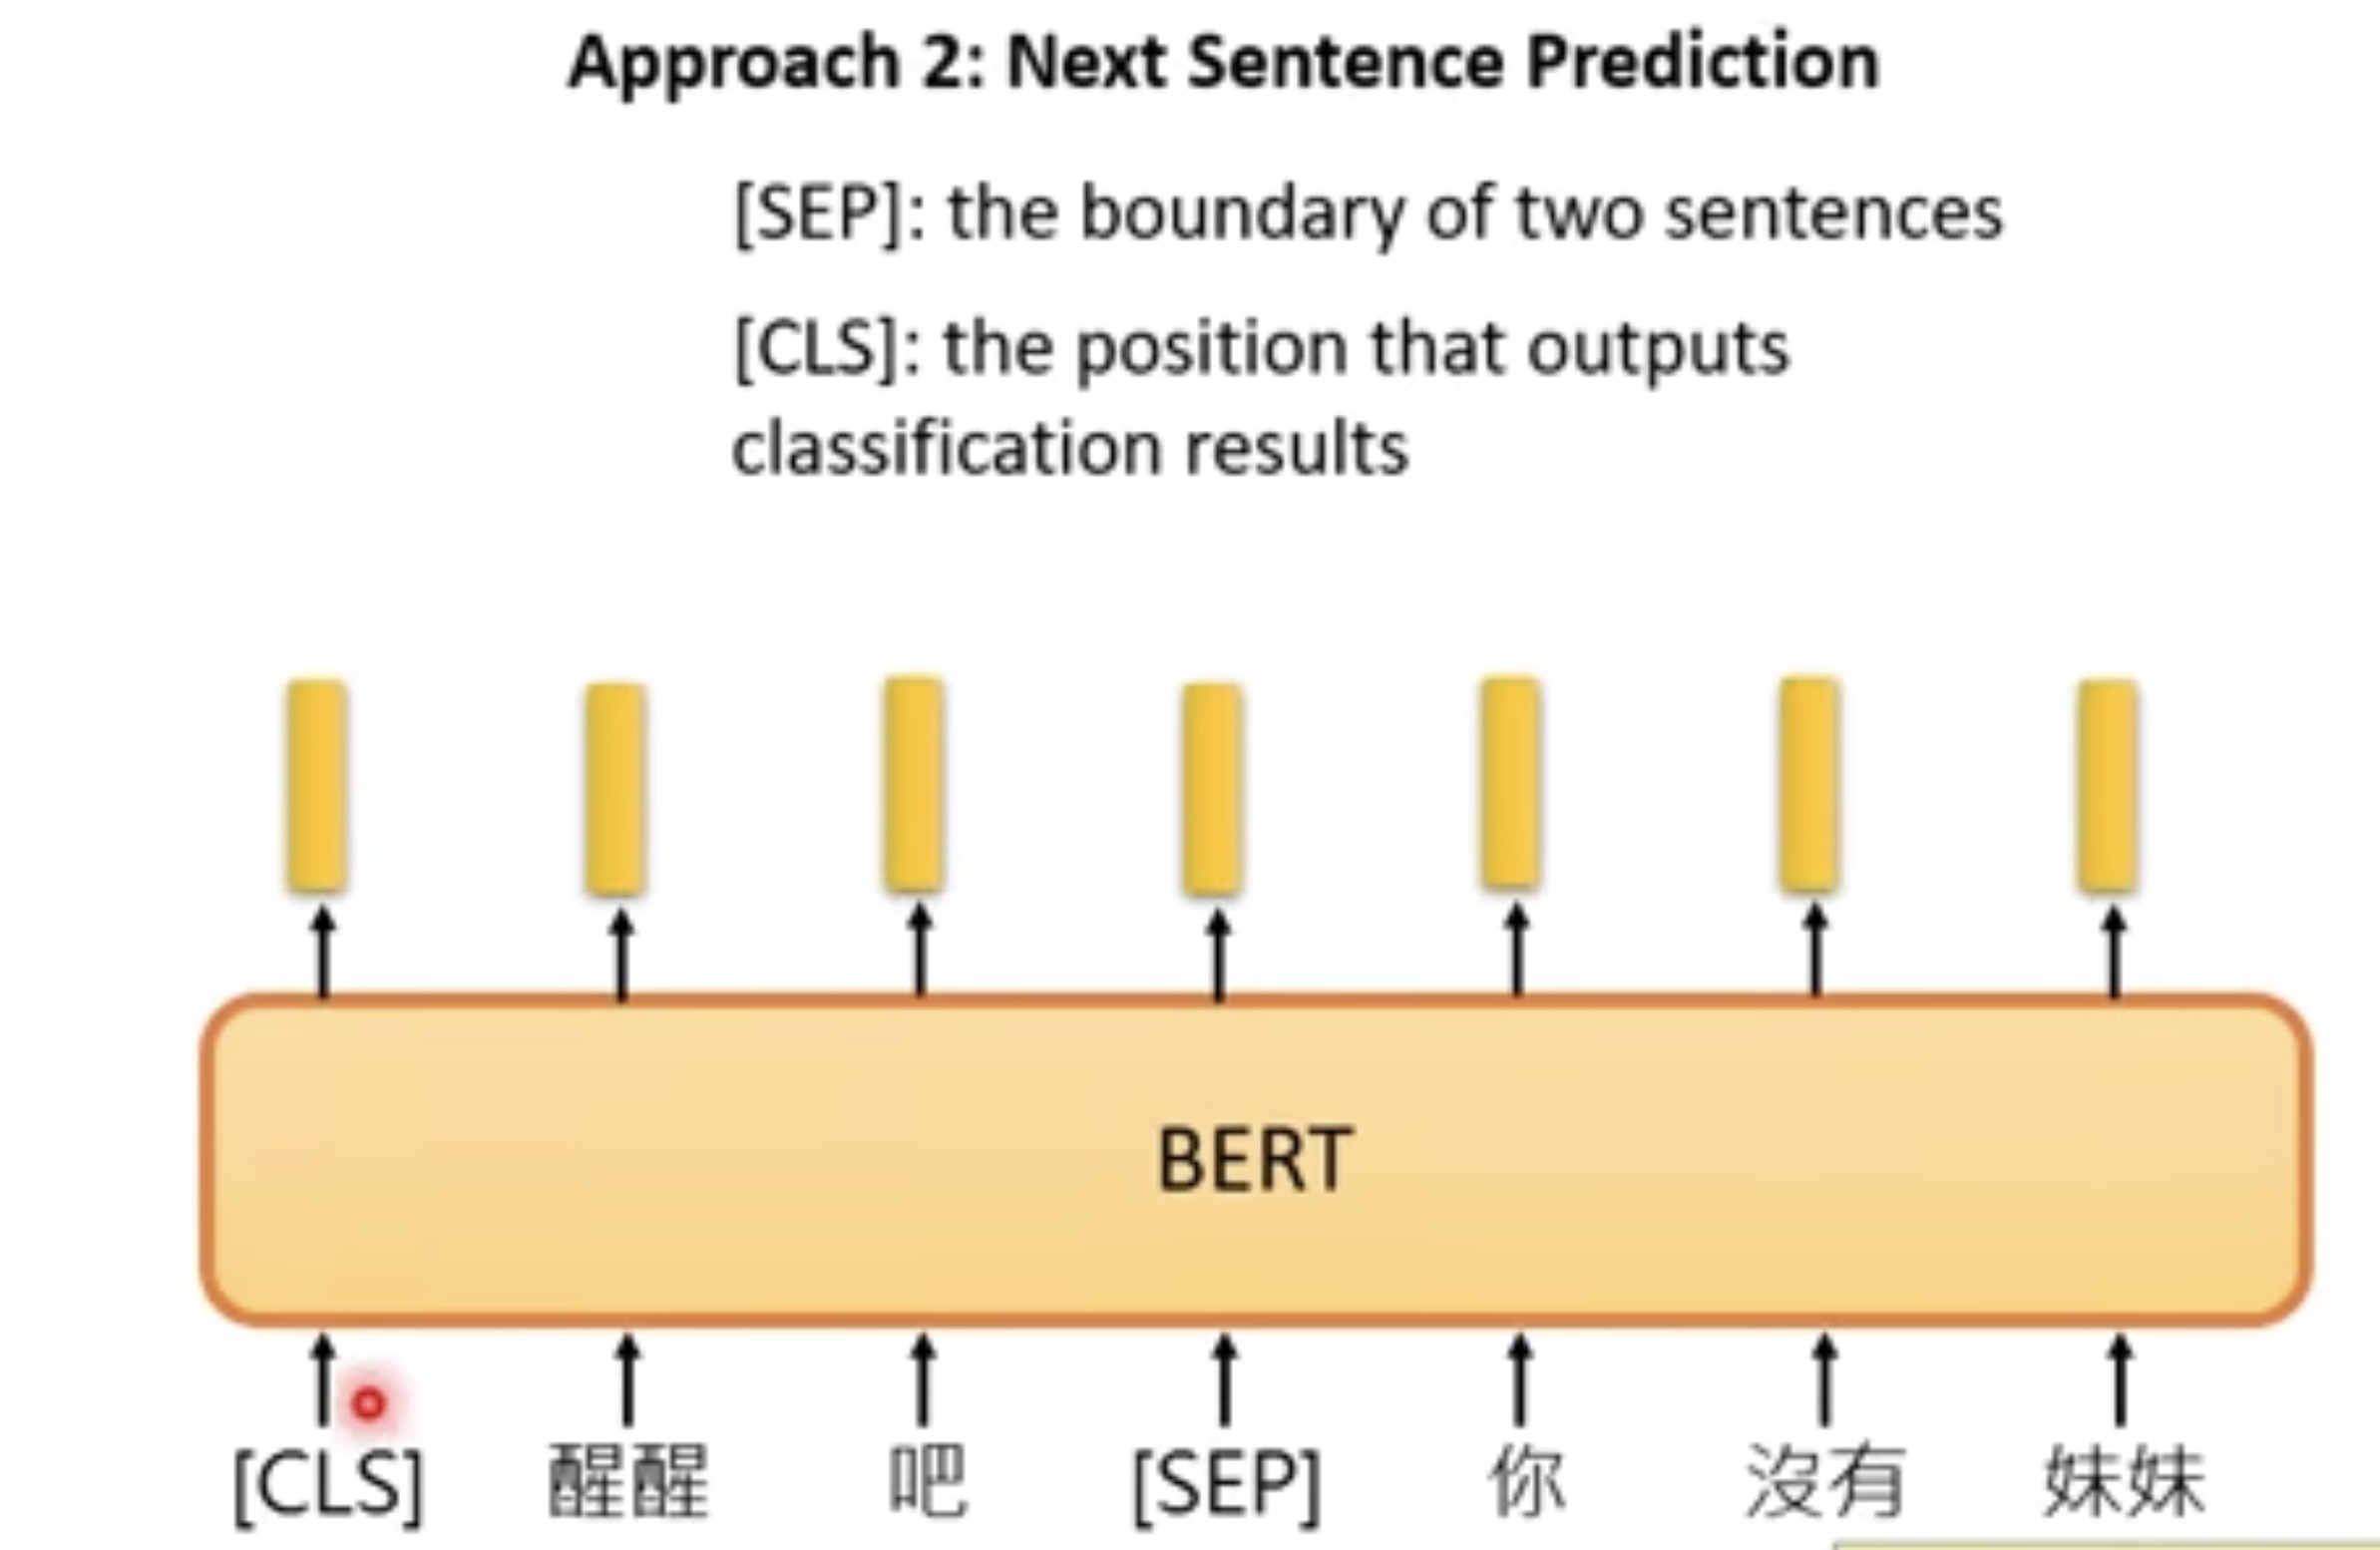

# Package

import sys

sys.version

In [10]:
import torch
import torchvision
import torchaudio
import numpy
torch.__version__, torchvision.__version__, torchaudio.__version__
from transformers import BertTokenizer, TFBertModel
from datasets import load_dataset

In [44]:
!pip install transformers
!pip install datasets
!pip install torchtext

# Tokenize data

In [5]:
data = load_dataset('ag_news')
print(data)
numpy.unique(data['train']['label'])

Found cached dataset ag_news (/Users/fionawu/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


array([0, 1, 2, 3])

In [12]:
# simple example of tokenize
tokenizer = BertTokenizer.from_pretrained(
    pretrained_model_name_or_path='bert-base-uncased')
input_data = data['train'][0]['text']
print(input_data)
out = tokenizer.encode(input_data)
print(out)
tokenizer.decode(out)

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
[101, 2813, 2358, 1012, 6468, 15020, 2067, 2046, 1996, 2304, 1006, 26665, 1007, 26665, 1011, 2460, 1011, 19041, 1010, 2813, 2395, 1005, 1055, 1040, 11101, 2989, 1032, 2316, 1997, 11087, 1011, 22330, 8713, 2015, 1010, 2024, 3773, 2665, 2153, 1012, 102]


"[CLS] wall st. bears claw back into the black ( reuters ) reuters - short - sellers, wall street's dwindling \\ band of ultra - cynics, are seeing green again. [SEP]"

In [13]:
import torch
from datasets import load_dataset

class Dataset(torch.utils.data.Dataset):
    def __init__(self, split):
        self.dataset = load_dataset('ag_news', split=split)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        text = self.dataset[i]['text']
        label = self.dataset[i]['label']

        return text, label


dataset = Dataset('train')

len(dataset), dataset[0]

Found cached dataset ag_news (/Users/fionawu/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


(120000,
 ("Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
  2))

In [14]:
from transformers import BertTokenizer
token = BertTokenizer.from_pretrained('bert-base-uncased')
token

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [15]:
def collate_fn(data):
    sents = [i[0] for i in data]
    labels = [i[1] for i in data]

    data = token.batch_encode_plus(batch_text_or_text_pairs=sents,
                                   truncation=True,
                                   padding='max_length',
                                   max_length=500,
                                   return_tensors='pt',
                                   return_length=True)

    input_ids = data['input_ids']
    attention_mask = data['attention_mask']
    token_type_ids = data['token_type_ids']
    labels = torch.LongTensor(labels)

    #print(data['length'], data['length'].max())

    return input_ids, attention_mask, token_type_ids, labels


loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=16,
                                     collate_fn=collate_fn,
                                     shuffle=True,
                                     drop_last=True)

for i, (input_ids, attention_mask, token_type_ids,
        labels) in enumerate(loader):
    print(i)
    break

print(len(loader)) # 7500 batch 
input_ids.shape, attention_mask.shape, token_type_ids.shape, labels

0
7500


(torch.Size([16, 500]),
 torch.Size([16, 500]),
 torch.Size([16, 500]),
 tensor([2, 2, 1, 2, 1, 0, 1, 1, 3, 3, 1, 2, 2, 2, 0, 3]))

# Model Train

In [17]:
from transformers import BertModel

pretrained = BertModel.from_pretrained('bert-base-uncased')

for param in pretrained.parameters():
    param.requires_grad_(False)  # use pre-trained model directly, no fine tuning 

out = pretrained(input_ids=input_ids,
           attention_mask=attention_mask,
           token_type_ids=token_type_ids)

out.last_hidden_state.shape  
# 16 batch-size
# 500 words
# 758 dimension for each words

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([16, 500, 768])

In [20]:
out

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0679,  0.2205,  0.1398,  ..., -0.4587,  0.8420, -0.0410],
         [-0.3844,  0.9246,  0.0691,  ..., -0.2590,  0.5163, -0.3772],
         [-0.0213,  0.0314,  0.4573,  ...,  0.1544,  0.8869, -0.2342],
         ...,
         [ 0.0268, -0.0758,  0.8853,  ..., -0.1672,  0.1293, -0.0258],
         [ 0.0132, -0.0767,  0.8838,  ..., -0.1820,  0.1568, -0.0049],
         [ 0.1441, -0.1287,  0.8716,  ..., -0.1539,  0.2135, -0.1450]],

        [[-0.7194, -0.5843,  0.5417,  ..., -0.4113,  0.7996, -0.0231],
         [ 0.9228, -0.3974, -0.2210,  ...,  0.1337,  1.0962,  0.2102],
         [-0.5495, -0.5163,  0.7926,  ...,  0.1127,  0.3136, -0.3873],
         ...,
         [-0.0705, -0.5477,  0.4247,  ..., -0.2169,  0.0490, -0.3354],
         [-0.2690, -0.5207,  0.2998,  ..., -0.1971, -0.1899, -0.3586],
         [-0.2269, -0.5562,  0.3814,  ..., -0.2779,  0.1377, -0.1352]],

        [[-0.2858, -0.2803, -0.4389,  ...,  0.3014,  

In [42]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask, token_type_ids):
        with torch.no_grad():
            out = pretrained(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids)

        out = self.fc(out.last_hidden_state[:, 0])

        out = out.softmax(dim=1)  
        # bert pre-trained model + fully connected linear + softmax

        return out


model = Model()

model(input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids).shape

torch.Size([16, 4])

In [43]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-4)
criterion = torch.nn.CrossEntropyLoss()

model.train()
for i, (input_ids, attention_mask, token_type_ids,
        labels) in enumerate(loader):
    out = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if i % 5 == 0:
        out = out.argmax(dim=1)
        accuracy = (out == labels).sum().item() / len(labels)

        print(i, loss.item(), accuracy)

    if i == 300:
        break

/Users/fionawu/opt/miniconda3/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0 1.3878848552703857 0.375
5 1.451101303100586 0.125
10 1.3804823160171509 0.375
15 1.4067546129226685 0.25
20 1.3873237371444702 0.25
25 1.4186923503875732 0.1875
30 1.2744879722595215 0.5625
35 1.2683054208755493 0.5625
40 1.2681771516799927 0.5625
45 1.2964133024215698 0.5
50 1.3157092332839966 0.3125
55 1.261474847793579 0.625
60 1.2016072273254395 0.75
65 1.2308193445205688 0.625
70 1.2358715534210205 0.625
75 1.2225663661956787 0.6875
80 1.1362526416778564 0.8125
85 1.1120465993881226 0.875
90 1.1061646938323975 0.8125
95 1.042372703552246 0.9375
100 1.0339436531066895 0.875
105 1.0764012336730957 0.9375
110 1.0811667442321777 0.8125
115 1.1485319137573242 0.8125
120 1.1994277238845825 0.5
125 1.0975879430770874 0.75
130 1.1760265827178955 0.625
135 1.1581043004989624 0.8125
140 1.0790804624557495 0.75
145 1.0630717277526855 0.8125
150 1.0615737438201904 0.75
155 1.0539854764938354 0.8125
160 1.0637364387512207 0.875
165 0.9914584159851074 0.875
170 1.0761535167694092 0.75
175 1.

#### BERT pre-trained model 抽取特征 + 简单的网络 就可以得到很好的分类效果

# Model Test

In [48]:
def test():
    model.eval()
    correct = 0
    total = 0

    loader_test = torch.utils.data.DataLoader(dataset=Dataset('test'),
                                              batch_size=32,
                                              collate_fn=collate_fn,
                                              shuffle=True,
                                              drop_last=True)

    for i, (input_ids, attention_mask, token_type_ids,
            labels) in enumerate(loader_test):

        if i == 10:
            break

        with torch.no_grad():
            out = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)

        out = out.argmax(dim=1)
        correct += (out == labels).sum().item()
        total += len(labels)

    print(correct / total)


test()

Found cached dataset ag_news (/Users/fionawu/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


0.7875


reference:    
https://github.com/lansinuote/Huggingface_Toturials/tree/main  
https://hackmd.io/@abliu/BkXmzDBmr